<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W3D1/tutorials/W3D1-RealNeurons/W3D1_Tutorial4_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spike timing dependent plasticity

## Objectives

In this notebook, we will build a model of synapse in which synaptic strength changes as a function of difference in the timing of pre- and post-synaptic neurons. This kind of change in the synaptic weight is known as **Spike timing dependent plasticity (STDP)**. In particular, we are going to write a few lines of code to:

1) build a model of synapse that show STDP

2) study how correlations in input spike trains influence the distribution of synapstic weights

We will model presynaptic input as Poisson type spike trains. The postsynaptic neuron will be modelled as LIF.
Throughout this tutorial we assume that a single postsynaptic neuron is drived by $N$ presynaptic neurons. That is, there are $N$ synapses and we will study how the weights of these $N$ synapses depend on the statistics or the input spike trains and their timing with respect to the post-synaptic neuron's spikes.


## Set up the code and initialize the notebook environment.

In [1]:
#@title Imports

import matplotlib.pyplot as plt    # import matplotlib
import numpy as np                 # import numpy
import time                        # import time
import ipywidgets as widgets       # interactive display
from scipy.stats import pearsonr   # import pearson correlation

fig_w, fig_h = (8, 6)
my_fontsize = 18
my_params = {'axes.labelsize': my_fontsize,
          'axes.titlesize': my_fontsize,
          'figure.figsize': (fig_w, fig_h),
          'font.size': my_fontsize,
          'legend.fontsize': my_fontsize-4,
          'lines.markersize': 8.,
          'lines.linewidth': 2.,
          'xtick.labelsize': my_fontsize-2,
          'ytick.labelsize': my_fontsize-2}

plt.rcParams.update(my_params)
my_layout = widgets.Layout()

In [2]:
#@title Poisson type spike trains generator
def Poisson_generator(pars, rate, n, myseed=False):
    
    '''
    Generates poisson trains
    Expects:
    pars       : parameter dictionary
    rate       : noise amplitute [Hz]
    n          : number of Poisson trains
    myseed     : random seed. int or boolean
    
    Returns:
    pre_spike_train : spike train matrix, ith row represents whether
                      there is a spike in ith spike train over time
                      (1 if spike, 0 otherwise)
    '''
    
    # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    
    # set random seed
    if myseed:
        np.random.seed(seed=myseed) 
    else:
        np.random.seed()
    
    # generate uniformly distributed random variables
    u_rand = np.random.rand(n, Lt)
    
    # generate Poisson train
    poisson_train = 1. * (u_rand<rate*dt/1000.)
    
    return poisson_train

print(help(Poisson_generator))

# the function plot the raster of the Poisson spike train
def my_raster_plot(range_t, spike_train, n):
    '''
    Generates poisson trains
    Expects:
    range_t     : time sequence 
    spike_train : binary spike trains, with shape (N, Lt)
    n           : number of Poisson trains plot
    
    Returns:
    Raster_plot of the spike train
    '''
    #find the number of all the spike trains
    N = spike_train.shape[0]

    # n should smaller than N:
    if n > N:
       print('The number n exceeds the size of spike trains')
       print('The number n is set to be the size of spike trains')
       n = N

    #plot rater
    i = 0
    while i<= n:
        if spike_train[i, :].sum()>0.:
          t_sp = range_t[spike_train[i, :]>0.5] #spike times 
          plt.plot(t_sp, i*np.ones(len(t_sp)), 'k|', ms=10, markeredgewidth=2)
        i += 1
    plt.xlim([range_t[0], range_t[-1]])
    plt.ylim([-0.5, n+0.5])    
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron ID')

def my_example_P():
    '''
    only for the P exercise cell
    '''
    spT = pre_spike_train_ex[pre_spike_train_ex.sum(axis=1)>0.,:]
    plt.figure(figsize=(7, 6))
    plt.subplot(211)
    color_set = ['r', 'b', 'k', 'orange', 'c']
    for i in range(spT.shape[0]):
        t_sp = pars['range_t'][spT[i, :]>0.5] #spike times 
        plt.plot(t_sp, i*np.ones(len(t_sp)), '|', color=color_set[i], 
                ms=10, markeredgewidth=2)
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron ID')
    plt.xlim(0, 200)

    plt.subplot(212)
    for k in range(5):
      plt.plot(pars['range_t'], P[k,:], color=color_set[k], lw=1.5)
    plt.xlabel('Time (s)')
    plt.ylabel('P(t)')
    plt.xlim(0, 200)

    plt.tight_layout()

Help on function Poisson_generator in module __main__:

Poisson_generator(pars, rate, n, myseed=False)
    Generates poisson trains
    Expects:
    pars       : parameter dictionary
    rate       : noise amplitute [Hz]
    n          : number of Poisson trains
    myseed     : random seed. int or boolean
    
    Returns:
    pre_spike_train : spike train matrix, ith row represents whether
                      there is a spike in ith spike train over time
                      (1 if spike, 0 otherwise)

None


## Spike timing dependent plasticity (STDP)

Phenomenology of STDP is generally described as a biphasic exponentially decaying function. That is, the instantaneous change in weights is given by:

\begin{align}
& \Delta W = A_+ e^{ (t_{pre}-t_{post})/\tau_+}  \hspace{10mm} \text{if} \hspace{5mm}  t_{post} > t_{pre}\\
& \Delta W =  -A_- e^{- (t_{pre}-t_{post})/\tau_-}   \hspace{7mm} \text{if} \hspace{5mm} t_{post} < t_{pre}
\end{align}

where $\Delta W$ is the change in the weight, $A_+$ and $A_-$ determine the maxmimum amount of synaptic modification (which occur when Δt is close to zero), $\tau_+$ and $\tau_-$ determine the ranges of pre-to-postsynaptic interspike intervals over which synaptic strengthening and weakening occur.

This model captures the pehnomenon that repeated occurrences of presynaptic spikes within a few milliseconds **before** postsynaptic action potentials lead to long-term potentiation (LTP) of the synapses, whereas repeated occurrences of spike **after** the postsynaptic spikes lead to long-term depression (LTD).

In the following latency between pre- and post-synaptic spike ($\Delta t$) is defined as: 
\begin{align}
\Delta t = t_{\rm pre} - t_{\rm post}
\end{align} 
where $t_{\rm pre}$ is time of pre-synaptic spike and $t_{\rm pre}$ is time of post-synaptic spike.
$\Delta w > 0 $ mean post-synaptic neuron spikes before pre-synaptic neuron.

Execute the following code to set the STDP parameters and plot the STDP function. For simplicity, we assume $\tau_{+} = \tau_{-} = \tau_{\rm stdp}$.

In [3]:
#@title Default parameters dictionary
def default_pars_STDP( **kwargs):
    pars = {}
    
    ### typical neuron parameters ###
    pars['V_th']    = -55. # spike threshold [mV]
    pars['V_reset'] = -75. # reset potential [mV]
    pars['tau_m']   = 10.  # membrane time constant [ms]
    pars['V_init']  = -65. # initial potential [mV]
    pars['V_L']     = -75. # leak reversal potential [mV]
    pars['tref']    = 2.   # refractory time (ms)
    
    ### STDP parameters ###
    pars['A_plus']   = 0.008               # magnitude of LTP
    pars['A_minus']  = pars['A_plus']*1.10 # magnitude of LTD
    pars['tau_stdp'] = 20.                 # STDP time constant [ms]

    ### simulation parameters ###
    pars['T'] = 400. # Total duration of simulation [ms]
    pars['dt'] = .1  # Simulation time step [ms]
    
    ### external parameters if any ###
    for k in kwargs:
        pars[k] = kwargs[k]
    
    pars['range_t'] = np.arange(0, pars['T'], pars['dt']) # Vector of discretized time points [ms]
        
    return pars

### Exrcise: Compute the STDP changes dW

Note as shown above, the expressions are different for $t_{post}>t_{pre}$ and $t_{post}<t_{pre}$. And here, we use `time_diff` describes $t_{pre}-t_{post}$.

After implementing the code, you can visualize the STDP kernel which describes by how much the synaptic weight will change given a latency between the pre- and post-synaptic spikes. 

In [4]:
# Exercise
def Delta_W(pars):
    '''
    Plot STDP biphasic exponential decaying function
    
    Expects:
    pars       : parameter dictionary
    
    Returns:
    dW         : instantaneous change in weights
    '''
    
    # Get parameters
    A_plus, A_minus, tau_stdp = pars['A_plus'], pars['A_minus'], pars['tau_stdp']
    
    #pre_spike time - post_spike time
    time_diff = np.linspace(-5*tau_stdp, 5*tau_stdp, 50)
    
    #STDP change
    dW = np.zeros(len(time_diff))
    #######################################################################
    ## TODO for students: compute dW, then remove the NotImplementedError #
    #######################################################################
    # Note for time_diff<=0, t_post>t_pre, LTP
    # dW =...
    # Note for time_diff>0, t_post<t_pre, LTD
    # dW =...

    raise NotImplementedError("Student excercise: compute the change STDP weight change")

    plt.figure()
    plt.plot([-5*tau_stdp,5*tau_stdp],[0,0],'k',linestyle=':')
    plt.plot([0,0],[-A_minus,A_plus],'k',linestyle=':')

    plt.plot(time_diff[time_diff<=0], dW[time_diff<=0], 'ro')
    plt.plot(time_diff[time_diff>0], dW[time_diff>0], 'bo')

    plt.xlabel(r't$_{\mathrm{pre}}$ - t$_{\mathrm{post}}$ (ms)')
    plt.ylabel(r'$\Delta$W',fontsize=12)
    plt.title('Biphasic STDP',fontsize=12, fontweight='bold')
    plt.show()

# Uncomment these lines after completing the Delta_W function    
# pars = default_pars_STDP()
# Delta_W(pars)  

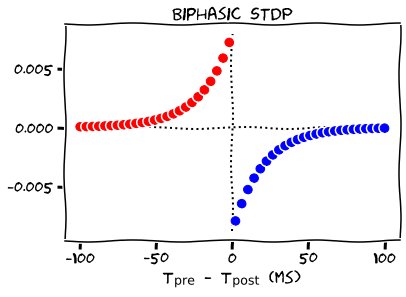

In [5]:
#remove solution
def Delta_W(pars):
    '''
    Plot STDP biphasic exponential decaying function
    
    Expects:
    pars       : parameter dictionary
    
    Returns:
    dW         : instantaneous change in weights
    '''
    
    # Get parameters
    A_plus, A_minus, tau_stdp = pars['A_plus'], pars['A_minus'], pars['tau_stdp']
    
    #pre_spike time - post_spike time
    time_diff = np.linspace(-5*tau_stdp, 5*tau_stdp, 50)
    
    #STDP change
    dW = np.zeros(len(time_diff))
    dW[time_diff<=0] = A_plus * np.exp(time_diff[time_diff<=0]/tau_stdp)  #LTP
    dW[time_diff>0] = -A_minus * np.exp(-time_diff[time_diff>0]/tau_stdp) #LTD

    with plt.xkcd():

      plt.figure()
      plt.plot([-5*tau_stdp,5*tau_stdp],[0,0],'k',linestyle=':')
      plt.plot([0,0],[-A_minus,A_plus],'k',linestyle=':')

      plt.plot(time_diff[time_diff<=0], dW[time_diff<=0], 'ro')
      plt.plot(time_diff[time_diff>0], dW[time_diff>0], 'bo')

      plt.xlabel(r't$_{\mathrm{pre}}$ - t$_{\mathrm{post}}$ (ms)')
      plt.title('Biphasic STDP', fontweight='bold')
      plt.show()
    
pars = default_pars_STDP()
Delta_W(pars)

### Keeping track of pre and postsynaptic spikes
Since a neuron will receive lots of presynaptic spike inputs, in order to implement STDP by taking into account different synapses, we first have to keep track of the pre and post synaptic spike times throughout the simulation. 

A convinient way to do this is to define the following equation for each post-synaptic neuron:
$$\tau_{-} \frac{dM}{dt} = -M$$

and whenever the postsynaptic neuron spikes, 
$$M(t) = M(t) - A_{-}$$

This way $M(t)$ tracks the number of postsynaptic spikes over the timescale $\tau_{-}$. 

Similarly for each presynaptic neuron we define:
$$\tau_{+} \frac{dP}{dt} = -P$$

and whenever there is spike on the presynaptic neuron,
$$P(t) = P(t) + A_{+}$$

The variables $M(t)$ and $P(t)$ are very similar to the equations for the synaptic conductances $g_i(t)$, except that they are used to keep track of pre and postsynaptic spike times on a much longer timescale. Note that $M(t)$ is always negative and $P(t)$ is always positive.  You can probably already guess that $M$ is used for LTD and $P$ for LTP because they are updated by $A_{-}$ and $A_{+}$, respectively. 

Note that $P(t)$ depends on the presynaptic spike stimes. When we already know the presynaptic spike times, $P$ can be generated before simulating the postsynaptic neuron and STDP.

### Visualization of $P$
Here we will consider a scenario in which there is a single postsynaptic neuron connected to $N$ presynaptic neurons. 

For instance, we have a one post-synaptic neuron which receives Poisson type spiking from five pre-synaptic neurons. 

We can simulate $P$ for each of the presynaptic neurons. 

### Exercise: Compute dP

Here we also use Euler scheme which should be introduced several times in the earler tutorial. Similar to the dynamics of membrane potential in LIF model, in a time step $dt$, $P(t)$ will decrease an amount of $\displaystyle{\frac{dt}{\tau_+}P(t)}$. While meeting a presynpatic spike, P(t) will directly increase an amount of $A_+$. Therefore, $dP = -\displaystyle{\frac{dt}{\tau_+}P(t)} + A_+\cdot \text{sp_or_not}$, where the sp_or_not is a binary value: 1 (spike in dt), 0 (no spike in dt).

In [6]:
# Exercise
def generate_P(pars, pre_spike_train_ex):
    '''
    track of pre-synaptic spikes
    
    Expects:
    pars               : parameter dictionary
    pre_spike_train_ex : binary spike train input from 
                         presynaptic excitatory neuron
    
    Returns:
    P  : LTP ratio
    '''
    
    # Get parameters
    A_plus, tau_stdp = pars['A_plus'], pars['tau_stdp']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    n_pre = pre_spike_train_ex.shape[0]
    
    #Initialize
    P = np.zeros(pre_spike_train_ex.shape)
    for it in range(Lt-1):
        #######################################################################
        ## TODO for students: compute dP, then remove the NotImplementedError #
        #######################################################################
        # dP = decay_part + (spike or not) * A_plus
        # Note the pre_spike_train_ex type, it is binary spike train already

        raise NotImplementedError("Student excercise: compute P, the change of presynaptic spike")

        P[:, it+1] = P[:, it] + dP
    
    return P

# Uncomment these lines after completing the generate_P function
# pars = default_pars_STDP(T=200., dt=1.)
# pre_spike_train_ex = Poisson_generator(pars, rate=10, n=5, myseed=202007)
# P = generate_P(pars, pre_spike_train_ex)
# my_example_P()

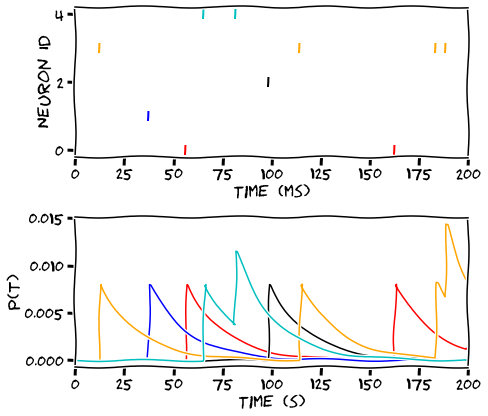

In [7]:
#remove solution
def generate_P(pars, pre_spike_train_ex):
    '''
    track of pre-synaptic spikes
    
    Expects:
    pars               : parameter dictionary
    pre_spike_train_ex : binary spike train input from 
                         presynaptic excitatory neuron
    
    Returns:
    P  : LTP ratio
    '''
    
    # Get parameters
    A_plus, tau_stdp = pars['A_plus'], pars['tau_stdp']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    n_pre = pre_spike_train_ex.shape[0]
    
    #Initialize
    P = np.zeros(pre_spike_train_ex.shape)
    for it in range(Lt-1):
        dP = -(dt/tau_stdp) * P[:, it] + A_plus*pre_spike_train_ex[:, it]  # delta increment
        P[:, it+1] = P[:, it] + dP
    
    return P

pars = default_pars_STDP(T=200., dt=1.)
pre_spike_train_ex = Poisson_generator(pars, rate=10, n=5, myseed=202007)
P = generate_P(pars, pre_spike_train_ex)
with plt.xkcd():
  my_example_P()

### Implementation of STDP

Finally, to implement STDP in spiking networks, we will change the value of the peak synaptic conductance based on the pre and post synaptic timing or the variable $P(t)$ and $M(t)$. 

Each synapse $i$ has its own peak synaptic conductance ($\bar g_i$) which may vary between $[0, \bar g_{max}]$, and will be modified depending on the pre and post synaptic timing. 

When the $ith$ presynaptic neuron elicits a spikes, its corresponding peak conductance is updated according to the following:
$$\bar g_i = \bar g_i + M(t)\bar g_{max} $$

Note that $M(t)$ tracks the time since the last postsynaptic potential and is negative. 

So if the postsynaptic neuron spikes shortly before the presynaptic neuron, the above equation means that the peak conductance will decrease. 

When the postsynaptic neuron spikes, peak conductance of each synapse is updated according to:
$$\bar g_i = \bar g_i + P_i(t)\bar g_{max} $$

Note that $P_i(t)$ tracks the time since the last spike of $ith$ presynaptic neuron. $P(t)$ is positive. So this equation means that if the presynaptic neuron spikes before the postsynaptic neuron, its peak conductance will increase.

### LIF neuron connected with synapses that show STDP 
In the following exercise we connect $N$ presynaptic neurons to a single post-synaptic neurons. We do not need to simulate the dynamics of each presynaptic neurons as we are only concerned about their spike times. So we will generate N Poisson type spikes. Here we will assume that all these inputs are excitatory. 

We need to simulate the dynamics of the postsynaptic neurons as we do not know its spike times. We model the postsynaptic neurona  as an LIF neuron receiving excitatory input

\begin{align}
\tau_m\frac{dV}{dt} = -(V-V_L) - g_E(t) (V(t)-V_E)\,
\end{align}

where total excitatory synaptic conductance is given as 
\begin{align}
g_E(t) = \sum_{i=1}^{N} g_i(t) \,
\end{align}

While simulating STDP it is important to make sure that $\bar g_i$ never goes outside of its bounds. 


In [8]:
#@title LIF with STFP: `run_LIF_cond_STDP(pars, pre_spike_train_ex)`
def run_LIF_cond_STDP(pars, pre_spike_train_ex):
    '''
    conductance-based LIF dynamics
    
    Expects:
    pars               : parameter dictionary
    pre_spike_train_ex : spike train input from presynaptic excitatory neuron
    
    Returns:
    rec_spikes : spike times
    rec_v      : mebrane potential
    gE         : postsynaptic excitatory conductance
    '''
    
    # Retrieve parameters
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m = pars['tau_m']
    V_init, V_L = pars['V_init'], pars['V_L']
    gE_bar, VE, tau_syn_E = pars['gE_bar'], pars['VE'], pars['tau_syn_E']
    gE_init = pars['gE_init']
    tref = pars['tref']
    A_plus, A_minus, tau_stdp = pars['A_plus'], pars['A_minus'], pars['tau_stdp']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    
    n_pre = pre_spike_train_ex.shape[0]
    P = generate_P(pars, pre_spike_train_ex)
    
    # Initialize
    tr = 0.
    v = np.zeros(Lt)
    v[0] = V_init
    M = np.zeros(Lt)
    gE = np.zeros(Lt)
    gE_bar_update = np.zeros(pre_spike_train_ex.shape)
    gE_bar_update[:, 0] = gE_init  # note: gE_bar is the maximum value
    
    # simulation
    rec_spikes = [] # recording spike times
    for it in range(Lt-1):
        if tr >0:
            v[it] = V_reset
            tr = tr-1
        elif v[it] >= V_th:         #reset voltage and record spike event
            rec_spikes.append(it)
            v[it] = V_reset
            M[it] = M[it] - A_minus
            gE_bar_update[:, it] = gE_bar_update[:, it] + P[:, it]*gE_bar
            id_temp = gE_bar_update[:, it] > gE_bar
            gE_bar_update[id_temp, it] = gE_bar
            tr = tref/dt

        #update the synaptic conductance
        M[it+1] = M[it] - dt / tau_stdp * M[it]
        gE[it+1] = gE[it] - (dt/tau_syn_E)*gE[it] + (gE_bar_update[:, it]*pre_spike_train_ex[:, it]).sum()
        gE_bar_update[:, it+1] = gE_bar_update[:, it] + M[it]*pre_spike_train_ex[:, it]*gE_bar
        id_temp = gE_bar_update[:, it+1] < 0
        gE_bar_update[id_temp, it+1] = 0.
     
        #calculate the increment of the membrane potential
        dv = (-(v[it]-V_L) - gE[it+1]*(v[it]-VE)) * (dt/tau_m)
        
        #update membrane potential
        v[it+1] = v[it] + dv
        
    rec_spikes = np.array(rec_spikes) * dt
        
    return v, rec_spikes, gE, P, M, gE_bar_update

### Evolution of excitatory synaptic conductance
In the following exercise we will simulate an LIF receiving input from $300$ presynaptic neurons to a single post-synaptic neurons.

In [9]:
pars = default_pars_STDP(T=200.,  dt=1.) # Simulation duration 200 ms
pars['gE_bar']    = 0.024   # max synaptic conductance
pars['gE_init']    = 0.024  # initial synaptic conductance
pars['VE']        = 0.   #[mV] Synapse reversal potential
pars['tau_syn_E'] = 5.   #[ms] EPSP time constant

# generate Poisson type spike trains
pre_spike_train_ex = Poisson_generator(pars, rate=10, n=300, myseed=2020)
# simulate the LIF neuron and record the synaptic conductance
v, rec_spikes, gE, P, M, gE_bar_update = run_LIF_cond_STDP(pars, pre_spike_train_ex)

#running the cell below to see the plots of the evolution of synaptic conductance

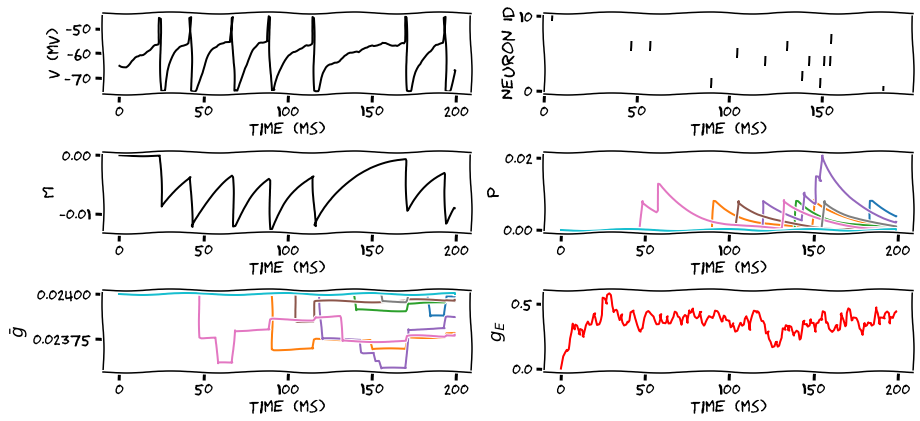

In [10]:
#@title Figures of the evolution of synaptic conductance
with plt.xkcd():
    plt.figure(figsize=(13., 6))
    plt.subplot(3,2,1)
    dt, range_t = pars['dt'], pars['range_t']
    if rec_spikes.size:
        sp_num = (rec_spikes/dt).astype(int)-1
        v[sp_num] += 10   #add artificial spikes
    plt.plot(pars['range_t'], v, 'k')
    plt.xlabel('Time (ms)')
    plt.ylabel('V (mV)');

    plt.subplot(3,2,2)
    # Plot the sample presynaptic spike trains
    my_raster_plot(pars['range_t'], pre_spike_train_ex, 10)


    plt.subplot(3,2,3)
    plt.plot(pars['range_t'], M, 'k')
    plt.xlabel('Time (ms)')
    plt.ylabel('M')

    plt.subplot(3,2,4)
    for i in range(10):
        plt.plot(pars['range_t'], P[i, :])
    plt.xlabel('Time (ms)')
    plt.ylabel('P')

    plt.subplot(3,2,5)
    for i in range(10):
        plt.plot(pars['range_t'], gE_bar_update[i, :])
    plt.xlabel('Time (ms)')
    plt.ylabel(r'$\bar g$')

    plt.subplot(3,2,6)
    plt.plot(pars['range_t'], gE, 'r')
    plt.xlabel('Time (ms)')
    plt.ylabel(r'$g_E$')

    plt.tight_layout()
    plt.show()

### Think
- In the above even though all the presynaptic neurons have the same average firing rate, many of the synapses seems to have been weakened? Did you expect that? 

- Total synaptic conductance is fluctuating over time. How do you expect $g_e$ to fluctuate if synapses did not show any STDP like behavior?

- Do synaptic weight every reach a stationary state when synapses show STDP? 

### Distribution of synaptic weight
From the above example we get an idea that some synapses depotentiate but what is the distribution of the synaptic weights when synapses show STDP? 

In fact, it is possible that even the synaptic weight distribution itself is a time-varying quantitiy. So we would like to know how the distribution of synaptic weightst evolve as a fucntion of time. 

To get a better estimate of the weight distribution and its time evolution we will increase the presynaptic firing rate to 15 Hz and simulate the plastic postsynaptic neuron for 120s. 

In [11]:
#@title Function `example_LIF_STD(inputrate=?, Tsim=120000.)`

def example_LIF_STD(inputrate=15., Tsim=120000.):
    '''
    Expect:
    intputrate  :  The rate used for generate presynaptic spike trains
    Tsim        :  Total simulation time

    output:
    Interactive demo: Visualization of synaptic weights
    '''

    pars = default_pars_STDP(T=Tsim,  dt=1.)
    pars['gE_bar']    = 0.024
    pars['gE_init']   = 0.014  # initial synaptic conductance
    pars['VE']        = 0.   #[mV]
    pars['tau_syn_E'] = 5.   #[ms]

    starttime = time.perf_counter()
    pre_spike_train_ex = Poisson_generator(pars, rate=inputrate, n=300, myseed=2020) # generate Poisson trains
    v, rec_spikes, gE, P, M, gE_bar_update = run_LIF_cond_STDP(pars, pre_spike_train_ex) # simulate LIF neuron with STDP
    gbar_norm = gE_bar_update/pars['gE_bar'] # calculate the ratio of the synaptic conductance
    endtime = time.perf_counter()
    timecost = (endtime - starttime)/60.

    print ('Total simulation time is %.3f min' % timecost)

    my_layout.width = '620px'
    @widgets.interact(
        sample_time = widgets.FloatSlider(0.5, min=0., max=1., step=0.1, layout=my_layout)
    )

    def my_visual_STDP_distribution(sample_time=0.0):
        
        sample_time = int(sample_time * pars['range_t'].size) - 1
        sample_time = sample_time*(sample_time>0)
        figtemp = plt.figure(figsize=(8, 8))
        ax1 = figtemp.add_axes([0.15, 0.55, 0.8, 0.27])
        for i in range(50):
            ax1.plot(pars['range_t'][::1000]/1000., gE_bar_update[i, ::1000], lw=1., alpha=0.7)

        ax1.axvline(1e-3*pars['range_t'][sample_time], 0., 1., color='k', ls='--')
        ax1.set_ylim(0, 0.025)
        ax1.set_xlim(-2, 122)
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel(r'$\bar{g}$')

        bins = np.arange(-.05,1.05,.05)
        g_dis, _ = np.histogram(gbar_norm[:, sample_time], bins)
        ax2 = figtemp.add_axes([0.15, 0.1, 0.8, 0.27])
        ax2.bar(bins[1:], g_dis, color='b', alpha=0.5, width=0.05)
        ax2.set_xlim(-0.1, 1.1)
        ax2.set_xlabel(r'$\bar{g}/g_{\mathrm{max}}$')
        ax2.set_ylabel('Number')
        ax2.set_title(('Time = %.1f s'%(1e-3*pars['range_t'][sample_time])), 
                  fontweight='bold') 
        plt.show()

print(help(example_LIF_STD))

Help on function example_LIF_STD in module __main__:

example_LIF_STD(inputrate=15.0, Tsim=120000.0)
    Expect:
    intputrate  :  The rate used for generate presynaptic spike trains
    Tsim        :  Total simulation time
    
    output:
    Interactive demo: Visualization of synaptic weights

None


In [12]:
example_LIF_STD(inputrate=15)

Total simulation time is 0.078 min


interactive(children=(FloatSlider(value=0.5, description='sample_time', layout=Layout(width='620px'), max=1.0)…

### Task
Increase the firing rate (i.e., 30 Hz) of presynaptic neurons, and investigate the effect on the dynamics of synaptic weight ditribution

### Effect of input correlations

Thus far we assumed that the input population was uncorrelated. What do you think will happen if presynaptic neurons were correlated? 

In the following we will modify the input such that first $C$ neurons have identical spike train while the remaining inputs are uncorrelated. This is a highly simplified model of introducing correlations. You can try to code your own model of correlated spike trains. 

In [13]:
#@title Function `example_LIF_STD_corrInput(inputrate=?, Tsim=120000.)`

def example_LIF_STD_corrInput(inputrate=20., Tsim=120000.):
    '''
    Expect:
    intputrate  :  The rate used for generate presynaptic spike trains
    Tsim        :  Total simulation time

    output:
    Interactive demo: Visualization of synaptic weights
    '''

    pars = default_pars_STDP(T=Tsim,  dt=1.)
    pars['gE_bar']    = 0.024
    pars['VE']        = 0.   #[mV]
    pars['gE_init']   = 0.024*np.random.rand(300)  # initial synaptic conductance
    pars['tau_syn_E'] = 5.   #[ms]

    starttime = time.perf_counter()
    pre_spike_train_ex = Poisson_generator(pars, rate=20, n=300, myseed=2020)
    for i_pre in range(50):
        pre_spike_train_ex[i_pre, :] = pre_spike_train_ex[0, :] # simple way to set input correlated
    v, rec_spikes, gE, P, M, gE_bar_update = run_LIF_cond_STDP(pars, pre_spike_train_ex) # simulate LIF neuron with STDP
    gbar_norm = gE_bar_update/pars['gE_bar'] # calculate the ratio of the synaptic conductance
    endtime = time.perf_counter()
    timecost = (endtime - starttime)/60.

    print ('Total simulation time is %.3f min' % timecost)

    my_layout.width = '620px'
    @widgets.interact(
        sample_time = widgets.FloatSlider(0.5, min=0., max=1., step=0.1, layout=my_layout)
    )

    def my_visual_STDP_distribution(sample_time=0.0):
        
        sample_time = int(sample_time * pars['range_t'].size) - 1
        sample_time = sample_time*(sample_time>0)
        figtemp = plt.figure(figsize=(8, 8))
        ax1 = figtemp.add_axes([0.15, 0.55, 0.8, 0.27])
        for i in range(50):
            ax1.plot(pars['range_t'][::1000]/1000., gE_bar_update[i, ::1000], lw=1., color='r', alpha=0.7, zorder=2)
        
        for i in range(50):
            ax1.plot(pars['range_t'][::1000]/1000., gE_bar_update[i+50, ::1000], lw=1., color='b', alpha=0.5, zorder=1)

        ax1.axvline(1e-3*pars['range_t'][sample_time], 0., 1., color='k', ls='--', zorder=2)
        ax1.set_ylim(0, 0.025)
        ax1.set_xlim(-2, 122)
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel(r'$\bar{g}$')
        legend=ax1.legend(['Correlated input', 'Uncorrelated iput'], fontsize=18,
                          loc=[0.92, -0.6], frameon=False)
        for color, text, item in zip(['r', 'b'], legend.get_texts(), legend.legendHandles):
            text.set_color(color)
            item.set_visible(False)

        bins = np.arange(-.05,1.05,.05)
        g_dis_cc, _ = np.histogram(gbar_norm[:50, sample_time], bins)
        g_dis_dp, _ = np.histogram(gbar_norm[50:, sample_time], bins)
        ax2 = figtemp.add_axes([0.15, 0.1, 0.8, 0.27])
        ax2.bar(bins[1:], g_dis_cc, color='r', alpha=0.5, width=0.05)
        ax2.bar(bins[1:], g_dis_dp, color='b', alpha=0.5, width=0.05)
        ax2.set_xlim(-0.1, 1.1)
        ax2.set_xlabel(r'$\bar{g}/g_{\mathrm{max}}$')
        ax2.set_ylabel('Number')
        ax2.set_title(('Time = %.1f s'%(1e-3*pars['range_t'][sample_time])), 
                  fontweight='bold') 
        plt.show()

print(help(example_LIF_STD_corrInput))

Help on function example_LIF_STD_corrInput in module __main__:

example_LIF_STD_corrInput(inputrate=20.0, Tsim=120000.0)
    Expect:
    intputrate  :  The rate used for generate presynaptic spike trains
    Tsim        :  Total simulation time
    
    output:
    Interactive demo: Visualization of synaptic weights

None


In [14]:
example_LIF_STD_corrInput(inputrate=20.0)

Total simulation time is 0.080 min


interactive(children=(FloatSlider(value=0.5, description='sample_time', layout=Layout(width='620px'), max=1.0)…

### Why do weights of uncorrelated neurons decrease when synapses show STDP
In the above we notice that the synapses of corrleate neurons (which spike together) were almost unaffected but the weights of other neurons diminished. Why does this happen? 

The reason is that the correlated presynaptic neurons have a higher chance of eliciting a spike in the postsynaptic neurons and that create a pre-> post pariing of spikes. 

### Task
Modify the code above and create two groups of correlated presynaptic neurons and test what happens to the weight distribution.

### Think
- How the above observations can be used to create unsupervised learning? Could you imagine what with such STDP rule we can train a neuron to identify certain input patterns?

- What else can be done with this type of plasticity?
